In [ ]:
# default_exp training

# Training Data

In [ ]:
#export
import random
import matplotlib.pyplot as plt
import numpy as np
import PIL
import chessocr
import re
import chess.pgn
import pandas as pd

from pathlib import Path
from PIL import Image, ImageDraw
from collections import namedtuple
from fastai.vision.all import *
from itertools import product
from IPython.core.pylabtools import print_figure
from random import randint
from random import shuffle
from random import choice
from collections.abc import *
from numpy.random import normal

In [ ]:
from chessocr.preprocess import *
from chessocr import preprocess
from fastai.data.all import *
URLs.chess_small

'https://chess-screenshots.s3.amazonaws.com/chess-small.tgz'

In [ ]:
websites_url = untar_data(URLs.website)

In [ ]:
#export
boards_url = Path(chessocr.__file__).parent.parent/"img/boards"
pieces_url = Path(chessocr.__file__).parent.parent/"img/pieces"
m = re.compile('^[0-9]+$')
piece_dirs = sorted([_ for _ in pieces_url.iterdir() if m.match(_.name)], key=lambda i: int(i.name))

## Boards and Board

In [ ]:
#export
def assert_coord(coord):
    assert len(coord)==2
    assert coord[0] in 'abcdefgh'
    assert coord[1] in '12345678'

In [ ]:
#export
class Board:
    """ 
        Represents a rendered board with particular dark and light colors.
        There are no pieces on the board.
        
        so far assumes the board is oriented towards the white player
    """
    _filemap=dict(zip('abcdefgh', '12345678'))
    _rankmap=dict(zip('12345678', '87654321'))
    def __init__(self, url): 
        self.url = url
        self.reset()
    def _repr_png_(self): return self.img._repr_png_()
    def reset(self): self.img = Image.open(self.url).convert('RGBA')
    def __getattr__(self, attr):
        if hasattr(self.img, attr): 
            return getattr(self.img, attr)
        else:
            raise AttributeError
    def bbox(self, coord):
        """ bounding box for chess coordinate like a8, b7, f6, etc """
        assert_coord(coord)
        file=int(self._filemap[coord[0]])-1
        rank=int(self._rankmap[coord[1]])-1
        dx=self.img.size[0]//8
        dy=self.img.size[1]//8
        x0=file*dx
        y0=rank*dy
        x1=x0+dx
        y1=y0+dy
        return (x0, y0, x1, y1,)

In [ ]:
Board(get_image_files(boards_url)[10]).bbox('a1')

(0, 350, 50, 400)

In [ ]:
Board(get_image_files(boards_url)[11]).bbox('a1')

(0, 350, 50, 400)

In [ ]:
get_image_files(boards_url)[11]

Path('/Users/id/nbs/07-chessocrnb/img/boards/21.png')

In [ ]:
#export
class Boards:
    """ 
        Container object holding `Board` objects.
    """
    def __init__(self, url):
        self.url = url
        self.boards = [Board(_) for _ in get_image_files(self.url)]
        self._png_data = None
    def __len__(self):          return len(self.boards)
    def __getitem__(self, key): return self.boards[key]
    def __setitem__(self, key, value): self.boards[key] = value
    def __iter__(self):         return iter(self.boards)
    def _repr_png_(self): 
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def _figure_data(self, format):
        rows = len(self) // 9 + 1
        fig, axs = plt.subplots(rows, 7, figsize=(14, 8))
        for i in range(len(self)):
            ax=axs.ravel()[i]
            ax.imshow(self[i].img)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_title(f"{i}")

        data = print_figure(fig)
        plt.close(fig)
        return data

In [ ]:
boards = Boards(boards_url)

In [ ]:
issubclass(Boards, Iterator)

False

In [ ]:
issubclass(Boards, MutableSequence)

False

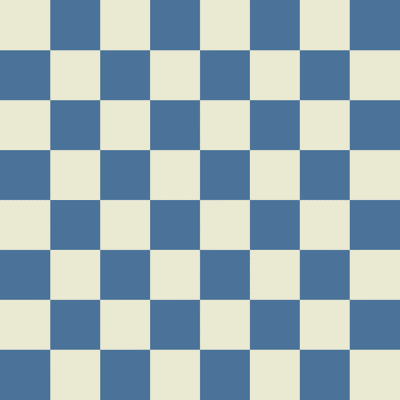

In [ ]:
shuffle(boards)
boards[27]

## PieceSet and PieceSets

In [ ]:
#export
class PieceSet:
    """ 
        Represents the 12 individual pieces comprising a chess set. 
        This includes a rook, knight, bishop, queen, king, and pawn for both black and white pieces.
    """
    _attrs = [f'{_[0]}{_[1]}' for _ in product('wb', 'rnbqkp')]
    
    def __init__(self, dir): 
        self.dir = dir
        self._png_data = None
        
    def _repr_png_(self):
        if not self._png_data:
            self._png_data = self._figure_data('png')
        return self._png_data

    def __getattr__(self, attr):
        if attr not in self._attrs: raise AttributeError
        return Image.open(self.dir/f'{attr[1]}_{attr[0]}.png').convert('RGBA')

    def _figure_data(self, format):
        fig, axs = plt.subplots(2, 6, gridspec_kw={'hspace':-0.5, 'wspace':0}, figsize=(8, 4))
        for i, attr in enumerate(list(self._attrs)):
            ax=axs.ravel()[i]
            ax.imshow(getattr(self, attr))
            ax.set_xticks([])
            ax.set_yticks([])
    
        fig.suptitle(self.dir.as_posix())
        data = print_figure(fig)
        plt.close(fig)
        return data

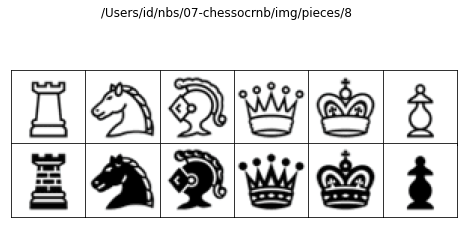

In [ ]:
PieceSet(choice(piece_dirs))

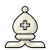

In [ ]:
PieceSet(choice(piece_dirs)).wb

In [ ]:
#export
class PieceSets:
    def __init__(self, dirs): self.sets = [PieceSet(_) for _ in dirs]
    def __getitem__(self, key): return self.sets[key]
    def __setitem__(self, key, value): self.sets[key] = value
    def __len__(self): return len(self.sets)

In [ ]:
#export
pieces=PieceSets(piece_dirs)

In [ ]:
shuffle(pieces)

## FEN

In [ ]:
#export
def converter(p):
    if p.isupper():
        return f'w{p.lower()}'
    else:
        return f'b{p.lower()}'

In [ ]:
#export
class FEN(Board):
    """ represents a fen string with convenience methods to find the piece on each square """
    
    _filemap=dict(zip('abcdefgh', range(0, 9)))
    _rankmap=dict(zip('12345678', range(0, 64, 8)[::-1]))    
    
    def __init__(self, fen):
        chars='RNBQKPrnbqkp/12345678'
        assert fen.count("/") == 7
        assert all([_ in chars for _ in fen])
        self.fen=fen
        assert len(self.fenfull)==64
        
    def __repr__(self):
        return self.fenfull
    
    def __str__(self): 
        return "\n".join([self.fenfull[0:8],
                          self.fenfull[8:16],
                          self.fenfull[16:24],
                          self.fenfull[24:32],
                          self.fenfull[32:40],
                          self.fenfull[40:48],
                          self.fenfull[48:56],
                          self.fenfull[56:], "\n"
                         ]) 
    
    @property
    def fenfull(self):
        """ fen rep with no numbers just to make things easier"""
        f = self.fen
        for i in '12345678': f=f.replace(i, '_'*int(i))
        return f.replace("/", "")

    def __iter__(self):
        return iter([(f'{f}{r}', converter(getattr(self, f'{f}{r}')),) 
                     for f, r, in product('abcdefgh', '12345678') 
                     if getattr(self, f'{f}{r}') != '_'])
    
    def __getattr__(self, attr):
        assert_coord(attr)
        file=self._filemap[attr[0]]
        rank=self._rankmap[attr[1]]
        idx = file+rank
        return self.fenfull[idx]

In [ ]:
s="rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR"
print(FEN(s))

rnbqkbnr
pppppppp
________
________
____P___
________
PPPP_PPP
RNBQKBNR




In [ ]:
start="rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR"
print(FEN(start))

rnbqkbnr
pppppppp
________
________
________
________
PPPPPPPP
RNBQKBNR




In [ ]:
test_eq(FEN(s).e4, 'P')
test_eq(FEN(s).a1, 'R')
test_eq(FEN(s).a8, 'r')
test_eq(FEN(s).h1, 'R')
test_eq(FEN(s).h8, 'r')
test_eq(FEN(s).e3, '_')
test_eq(FEN(s).e1, 'K')
test_eq(FEN(s).e8, 'k')
test_eq(FEN(s).c5, '_')

## GameBoard

In [ ]:
#export
class GameBoard:
    """
        Represents a combination of a Board, PieceSet, and optionally a FEN to create the position.
        If no fen is provided, the GameBoard will be in the starting position
    """
    def __init__(self, board, pieces, fen=FEN("rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR")):
        self.board = board
        self.pieces = pieces
        self.fen=fen
        self._render()
        
    def _render(self):
        if not self.fen:
            return
        for s, p in self.fen:
            img=self.board.img
            board=self.board
            pieces=self.pieces
            img.paste(getattr(pieces, p), board.bbox(s), getattr(pieces, p))
        
    def _repr_png_(self):
        return self.board._repr_png_()

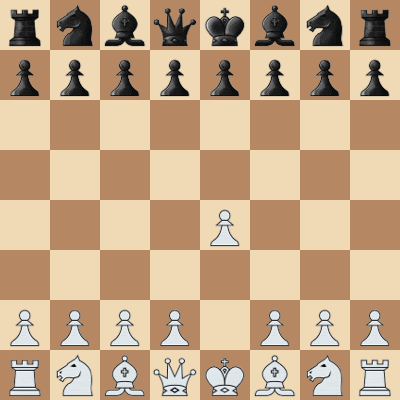

In [ ]:
board = choice(boards)
board.reset()
piece = choice(pieces)
gb = GameBoard(board, piece, FEN(s)); gb

## FEN Generator

In [ ]:
#export
pgn_url = Path(chessocr.__file__).parent.parent/"pgn"
pgn = pgn_url/"Kasparov.pgn"
small = pgn_url/"small.pgn"

In [ ]:
#export
def game(path):
    """ generator through all the pgns in a file """
    with open(path) as pgn:
        while True:
            try: 
                game = chess.pgn.read_game(pgn)
            except UnicodeDecodeError: 
                continue
            if game is None: 
                break
            yield game

In [ ]:
#export
def fen(path):
    """ generator through all the fens in a game object the pgns in a file """
    for g in game(path):        
        board = g.board()
        for move in g.mainline_moves():
            board.push(move)
            yield board.fen().split()[0]

In [ ]:
#export
fens = [FEN(_) for _ in fen(pgn)]

## Backgrounds

In [ ]:
#export
sites = get_image_files(websites_url)

## Render

In [ ]:
#export
class Render:
    """ creates a training sample from the constituent parts """
    def __init__(self, board, piece, fen, backurl):
        self.board=board
        self.piece=piece
        self.fen=fen
        self.backurl=backurl
        self.background=Image.open(self.backurl)
        self.gameboard=GameBoard(self.board, self.piece, self.fen)
        self._render()
    
    def _render(self):
        size = max(min(int(normal(board.size[0], board.size[0]/3)), min(self.background.size)), 100)
        dx = int(random.uniform(0, self.background.size[0] - size))
        dy = int(random.uniform(0, self.background.size[1] - size))
        self.background.paste(self.board.resize((size, size)), (dx, dy, dx+size, dy+size))
        self.size,self.dx,self.dy = size, dx, dy
    
    def label(self):
        return (self.size, self.dx, self.dy, self.backurl.name, self.fen, self.board.url.name,
               self.piece.dir.name)

    def __getattr__(self, attr):...
    
    def _repr_png_(self):
        ratio=0.5
        return self.background.resize((int(self.background.shape[1]*ratio), 
                                      int(self.background.shape[0]*ratio)))._repr_png_()

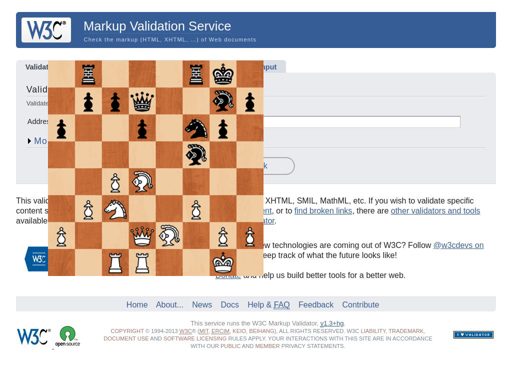

(431,
 96,
 121,
 'validator_w3_org_png.rf.83d71f54478a290ab8da0561f34464b2.jpg',
 _r___rk__ppq__bpp__p_np______b____PB_____PN__P__P__QB_PP__RR__K_,
 '2.png',
 '8')

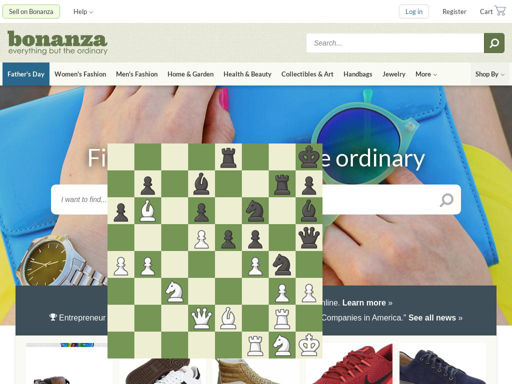

(430,
 215,
 287,
 'bonanza_com_png.rf.10250c140f2d77c6b405aaaa0154077a.jpg',
 ____r__k_p_b__rppB_p_n_b___Ppp_qPP___Pn___N___PP___QB_R______RNK,
 '11.png',
 '22')

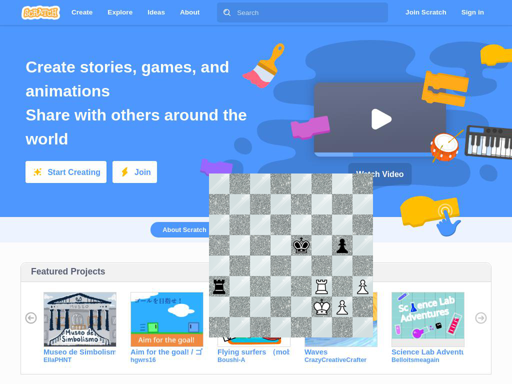

(328,
 418,
 347,
 'scratch_mit_edu_png.rf.90e1b5bafe335b10f0ccf666207777db.jpg',
 ____________________________k_p_________r____R_P_____KP_________,
 '14.png',
 '1')

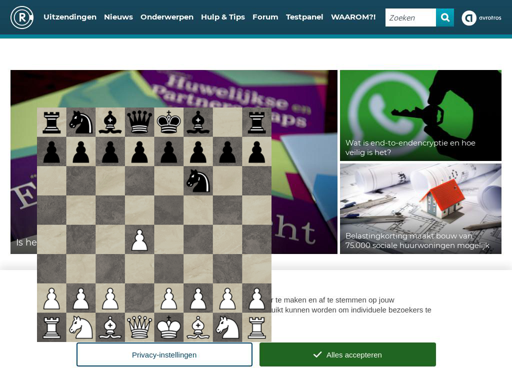

(469,
 74,
 215,
 'radar_avrotros_nl_png.rf.589766bd050d0e759ff0a6c68f5e5936.jpg',
 rnbqkb_rpppppppp_____n_____________P____________PPP_PPPPRNBQKBNR,
 '15.png',
 '14')

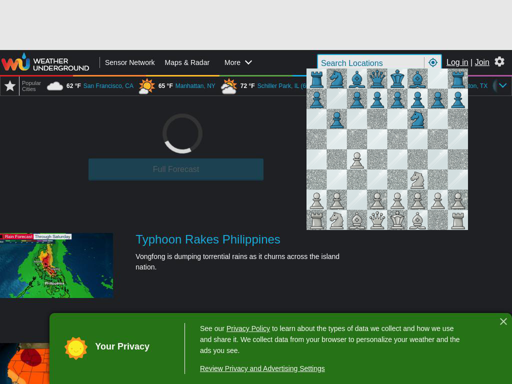

(323,
 613,
 137,
 'wunderground_com_png.rf.f306f2156a900ed6a8af94e926c61a21.jpg',
 rnbqkb_rp_pppppp_p___n____________P__________N__PP_PPPPPRNBQKB_R,
 '14.png',
 '27')

In [ ]:
#export
for i in range(5):
    board=choice(boards)
    board.reset()
    render = Render(board, choice(pieces), choice(fens), choice(sites))
    render; render.label()

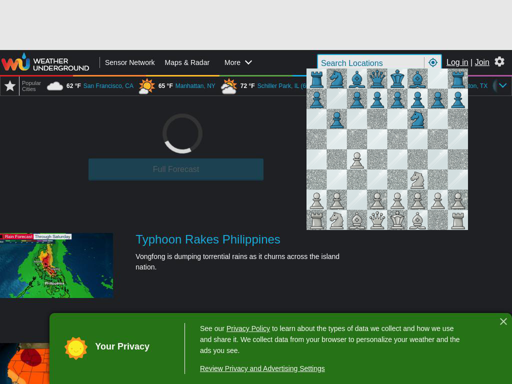

In [ ]:
render